In [22]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pandas.io.sql as sqlio
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import time
import psycopg2 #To connect to server
import geopandas as gpd
import geoplot

In [3]:
# Connecting to the server
conn = psycopg2.connect('THIS INFORMATION IS PRIVATE'')

# Loading stations tables

In [4]:
#Getting stations raw list
sql = f'SELECT * FROM dimension.dimestacion;'
stations = sqlio.read_sql_query(sql, conn)
stations.head()

,idestacion,recaudoestacion,nombreestacion,estadoregistro,idlinea,latitud,longitud
0,393,50001,(50001) Portal Eldorado[Intermedium],0,NaN,NaN,NaN
1,365,40000,(40000) Cable Portal Tunal,0,NaN,NaN,NaN
2,366,40002,(40002) Manitas,0,NaN,NaN,NaN
3,367,40001,(40001) Juan Pablo II,0,NaN,NaN,NaN
4,368,40004,(40004) Bicicletero Mirador del Paraíso,0,NaN,NaN,NaN


In [5]:
#General table description
print(stations.isnull().sum())
print('')
print(stations.info())

idestacion          0
recaudoestacion     0
nombreestacion      0
estadoregistro      0
idlinea            16
latitud            36
longitud           38
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394 entries, 0 to 393
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   idestacion       394 non-null    int64  
 1   recaudoestacion  394 non-null    object 
 2   nombreestacion   394 non-null    object 
 3   estadoregistro   394 non-null    int64  
 4   idlinea          378 non-null    float64
 5   latitud          358 non-null    float64
 6   longitud         356 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 21.7+ KB
None


- From the above result, we can see that the stations table is missing latitude and longitude information form 36 and 38 stations respectively. There is also column called "idlinea" that has 16 missing observations. 

- There should be some repeated stations because, as of April 2019, Transmilenio only has 143 regular stations and 9 main stations, that is a total of 152 unique stations. 

## BRT Stations data cleaning 

In [ ]:
print ('number of unique stations: ', stations.idestacion.nunique())
print ('number of unique fare colletion station:',stations.recaudoestacion.nunique())

It seems that the fare collection id is more accurate with the total number of unique stations in the system

In [7]:
stations.sort_values('recaudoestacion').head(20)

,idestacion,recaudoestacion,nombreestacion,estadoregistro,idlinea,latitud,longitud
262,167,,0,1,0.0,NaN,NaN
266,0,0,Sin Estacion,1,0.0,NaN,NaN
252,14,00000,no valido(00000),0,0.0,NaN,NaN
81,392,01234,Pruebas(01234),0,NaN,NaN,NaN
363,329,02000,(02000) Cabecera Autopista Norte,0,304.0,4.75451,-74.0461
205,150,02000,Cabecera Autopista Norte(02000),0,304.0,4.75451,-74.0461
261,155,02001,Centro Comercial Santa Fe(02001),0,0.0,NaN,NaN
320,231,02001,(02001) Centro Comercial Santa Fe,0,304.0,NaN,NaN
306,138,02101,Tober?n(02101),0,304.0,4.74694,-74.0472
250,356,02101,Tober�n(02101),0,304.0,4.74694,-74.0472


- There are "virtual stations" that are probably craeated for testing. Also, there seems to be that "recaudoestacion" is a better id for the estacion. However, we need to keep both because the 'idestacion' link this table to the tap-in table. Also, it seems that there are some stations that have change the name overtime, as seem on 'recaudoestacion' 02102 (Not so clear from the data, but a quick google serach clarify that "cardio infantil" station change to "calle 161" station. There were more changes of stations)

- As I only have reading options of the sql tables, I'll need to make sure to filter out non valid estations estations from my analysis

In [8]:
def cleaning_stations(data):
    '''
    Input: 
    - data: row Pandas DataFrame with information about the stations
    
    Output: 
    - a geopandas dataframe with all relevant stations and geometry(x,y coordinate as points) 
    '''

    mask = data.recaudoestacion.isin(['', '0', '00000', '01234', '06112', '22000', '12345'])
    exclude_stations = tuple(data.recaudoestacion[mask])
    
#     #Grupping by recaudoestacion because is a better id for the estation
#     df = data[~mask].groupby('recaudoestacion')\
#                 [['nombreestacion','idlinea','latitud','longitud']].first().reset_index()
    
#     #There are 10 duplicated stations (ID is different, but station should be the same)
#     duplicated = {'04100':'04004', '57503':'07503', '50001':'04100','08100':'40000','40004':'40003',
#                   '50002':'09100', '50003':'09001', '50004':'04003', '50006':'04100', '50007':'07006',}
    
#     df.recaudoestacion = df.recaudoestacion.replace(duplicated)
    df = data[~mask].copy()
    
    missing_xy = {'(50001) Portal Eldorado[Intermedium]' : (4.681520, -74.121143),
              '(40000) Cable Portal Tunal': (4.568481,-74.139379),
              '(40001) Juan Pablo II': (4.555476,-74.147523),
              '(40002) Manitas': (4.550445,-74.150598),
              '(40003) Mirador del Paraiso': (4.550019,-74.159009),
              '(40004) Bicicletero Mirador del Paraíso': (4.550019,-74.159009),
              '(08100) Portal Tunal Cable': (4.568481,-74.139379),
              'Cable Portal Tunal(40000)' : (4.568481,-74.139379),
              'Juan Pablo II(40001)' : (4.555476,-74.147523),
              'Manitas(40002)' : (4.550445,-74.150598),
              'Mirador del Paraiso(40003)': (4.550019,-74.159009),
              '(14005) Las Aguas': (4.60255, -74.068687),
              'Ampliacion San Mateo(57503)': (4.589146,-74.199496),
              'Corral Molinos(50003)': (4.556805,-74.121705),
              'Corral Avenida Ciudad de Cali(50004)':(4.702865,-74.100733),
              'Corral Calle 40 Sur(50002)':(4.575937,-74.119233),
              'EL CAMPIN(07106)':(4.645663,-74.078697),
              'Corral General Santander(50007)':(4.593200,-74.128343),
              'Corral Carrera 77(50006)': (4.698383,-74.094176),
              'Centro Comercial Santa Fe(02001)':(4.763741, -74.044402),
              'Las Aguas(14005)':(4.60255, -74.068687),
              '(50007) Corral General Santander': (4.593200,-74.128343),
              '(07106) EL CAMPIN':(4.645663,-74.078697),
              '(02001) Centro Comercial Santa Fe': (4.763741, -74.044402),
              '(50003) Corral Molinos':(4.556805,-74.121705),
              '(50004) Corral Avenida Ciudad de Cali':(4.702865,-74.100733),
              '(50002) Corral Calle 40 Sur':(4.575937,-74.119233),
              '(57503) Ampliacion San Mateo':(4.589146,-74.199496),
              '(50006) Corral Carrera 77':(4.698383,-74.094176)}

    for key, value in missing_xy.items():
        df.loc[df[df.nombreestacion == key].index[0], ['latitud', 'longitud']] = value
        
    gdf = gpd.GeoDataFrame(df, 
                 geometry = gpd.points_from_xy(df.longitud, df.latitud))
    
    return gdf

In [9]:
stations = cleaning_stations(stations)
stations.isnull().sum()

idestacion          0
recaudoestacion     0
nombreestacion      0
estadoregistro      0
idlinea            15
latitud             0
longitud            0
geometry            0
dtype: int64

Note: I did not impute/compleate idlinea because it is irrelevant for my analysis. 

# Assing a strata to a station

Strata is a Colombian socio-demographic varible that is highly correlated with income. The higher strata, the higher income. In general, each stations serves aproximately one type of strata. 

To assign a strata to each station, we laverage on the fact that strata is spatilly clustered. Higher strata is mainly located in the center of the city, and lower stata tends to be in the outskirts. 

### Data: 
- (1) Strata by block (link to data) 
- (2) Stations lat and lon coordinates

### Methodology 
(Initial approach, we could refine this, but for now, this will sufice):
- For each station, we create a buffer of ~500m (average spacing among stations). 
- Spatial join of ~500m station buffer and blocks. 
- Calculate the average strata of the blocks within each buffer and round it to the closest integer. 
 

In [24]:
# Strata by the block file 
path = '/Users/juandavidcaicedocastro/Documents/BERKELEY/17_PhD/02_Data/03_Transmilenio/02_255 project/data/02_manzanaestratificacion/ManzanaEstratificacion.shp'
blocks = gpd.read_file(path)

In [31]:
def assign_strata(stations, blocks):
    
    #Creating buffer ~500m 
    stations['catchment_area'] = stations.geometry.buffer(0.005) # 0.001° = 111 m
    stations_buffer = gpd.GeoDataFrame(stations, geometry = 'catchment_area')
    
    # Spatial Join stations buffer and blocks
    estacion_estrata = gpd.sjoin(stations_buffer, blocks, how = 'left', op = 'intersects' )
    
    # Average strata by BRT station 
    strata = estacion_estrata.groupby('idestacion').agg({'recaudoestacion':'first',
                                                     'nombreestacion':'first',
                                                     'ESTRATO':'mean',
                                                     'latitud':'first',
                                                     'longitud':'first',
                                                     'geometry':'first'})
    
    # BRT stations outside the Bogota Metro Region are only located in Soacha, with a strata of 1. 
    strata.ESTRATO.fillna(1, inplace = True) # Replace nan values with strata 1
    strata.ESTRATO = strata.ESTRATO.round(decimals = 0).astype(int)
    
    return gpd.GeoDataFrame(strata, geometry = 'geometry')
    

In [34]:
assign_strata(stations,blocks)

,recaudoestacion,nombreestacion,ESTRATO,latitud,longitud,geometry
idestacion,,,,,,
1,05105,Pradera(05105),2,4.62861,-74.119700,POINT (-74.11970 4.62861)
2,10004,Policarpa(10004),2,4.58616,-74.087000,POINT (-74.08700 4.58616)
3,04002,Carrera 90(04002),2,4.70446,-74.104200,POINT (-74.10420 4.70446)
4,03000,Portal Suba(03000),2,4.74675,-74.094300,POINT (-74.09430 4.74675)
5,10005,Bicentenario(10005),2,4.59359,-74.082100,POINT (-74.08210 4.59359)
...,...,...,...,...,...,...
388,05102,Av. Am?ricas Av. Boyac?(05102),3,4.63014,-74.135200,POINT (-74.13520 4.63014)
389,07200,TyguaSan José(07200),3,4.59967,-74.088700,POINT (-74.08870 4.59967)
390,05102,Av. Américas Av. Boyacá(05102),3,4.63014,-74.135200,POINT (-74.13520 4.63014)


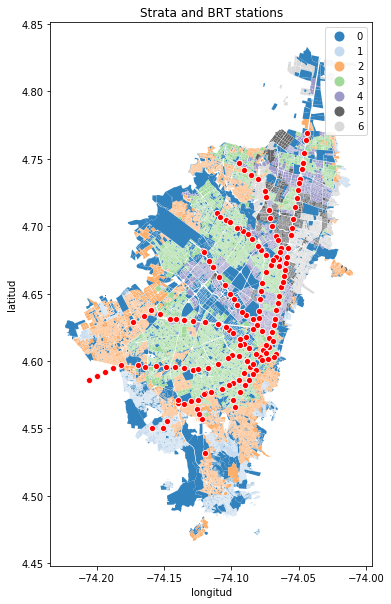

In [25]:
# Strata and transmilenio stations 
fig, ax = plt.subplots(figsize = (10,10))
blocks.plot(column = 'ESTRATO', ax = ax, legend = True, cmap = 'tab20c', categorical = True)
sns.scatterplot(x = 'longitud', y = 'latitud', data = stations, ax = ax, color ='r')
plt.title('Strata and BRT stations');

In [26]:
# Create BRT station buffers 
stations['catchment_area'] = stations.geometry.buffer(0.005) # 0.001° = 111 m
stations_buffer = gpd.GeoDataFrame(stations, geometry = 'catchment_area')

In [27]:
# Spatial Join stations buffer and blocks
estacion_estrata = gpd.sjoin(stations_buffer, blocks, how = 'left', op = 'intersects' )

In [28]:
# Average strata by BRT station 
strata = estacion_estrata.groupby('idestacion').agg({'recaudoestacion':'first',
                                                     'nombreestacion':'first',
                                                     'ESTRATO':'mean',
                                                     'latitud':'first',
                                                     'longitud':'first',
                                                     'geometry':'first'})

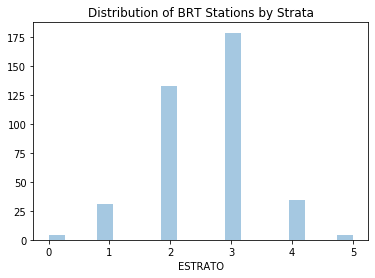

In [29]:
# BRT stations outside the Bogota Metro Region are only located in Soacha, with a strata of 1. 
strata.ESTRATO.fillna(1, inplace = True) # Replace nan values with strata 1
strata.ESTRATO = strata.ESTRATO.round(decimals = 0).astype(int)
strata.sort_values('ESTRATO')
strata = gpd.GeoDataFrame(strata, geometry = 'geometry')
sns.distplot(strata.ESTRATO, kde = False)
plt.title('Distribution of BRT Stations by Strata');

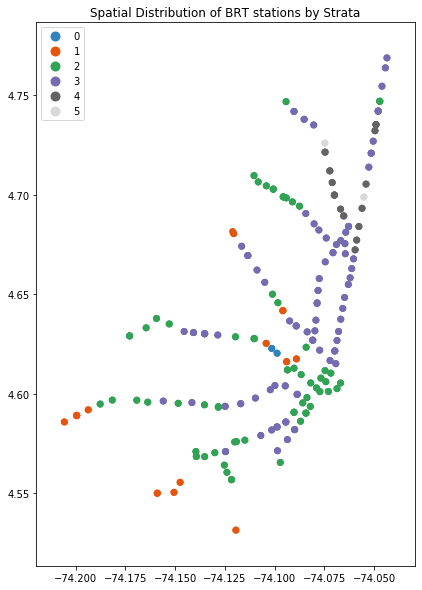

In [30]:
# map brt stations and strata 
fig, ax = plt.subplots(figsize = (10,10))
strata.plot(column = 'ESTRATO', ax = ax, legend = True, cmap = 'tab20c', categorical = True)
plt.title('Spatial Distribution of BRT stations by Strata');